In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('vgchartz_2024.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           22940 non-null  object 
 1   title         22940 non-null  object 
 2   console       22940 non-null  object 
 3   genre         22939 non-null  object 
 4   publisher     22939 non-null  object 
 5   developer     22934 non-null  object 
 6   critic_score  4405 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  22494 non-null  object 
 13  last_update   4553 non-null   object 
dtypes: float64(6), object(8)
memory usage: 2.5+ MB


##Limpieza de datos y análisis exploratorio

In [3]:
data.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [4]:
data.isna().sum()

,0
img,0
title,0
console,0
genre,1
publisher,1
developer,6
critic_score,18535
total_sales,4018
na_sales,10303
jp_sales,16214


Se eliminan filas con valores faltantes de columnas importantes para el análisis

In [5]:
data = data.dropna(subset=['total_sales', 'critic_score'])

#Estadísticas de las variables numéricas
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_columns].describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,4126.000000,4126.000000,3738.000000,1402.000000,3779.000000,4003.000000
mean,7.101890,0.737230,0.416581,0.108959,0.263697,0.083560
std,1.439307,1.408497,0.734706,0.162062,0.612218,0.199425
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,0.110000,0.080000,0.020000,0.020000,0.010000
50%,7.300000,0.300000,0.180000,0.050000,0.070000,0.020000
75%,8.100000,0.750000,0.430000,0.130000,0.250000,0.080000
max,10.000000,20.320000,9.760000,1.870000,9.850000,3.120000


##Construcción de la variable objetivo

La popularidad de un videojuego puede depender del grupo social, región geográfica, tendencias, plataforma en que se juega y otros factores. Sin embargo, para la implementación del modelo, se realizó una aproximación a partir del total de ventas y la calificación otorgada al juego.
Para determinar la categoría de popularidad se definió un indicador, donde el  total de ventas contribuye con un peso del 80%  y la calificación dada al juego con un 20%. Porteriormente, se utilizó el indicador para clasificar como "Muy popular" a los videojuegos que pertenecen al 15% más alto del indicador, como "Moderadamente popular" al 20% siguiente  y como "Menos popular" al 65% restante .

In [58]:
scaler = MinMaxScaler()

# Normalizar ventas y calificaciones
data['total_sales_norm'] = scaler.fit_transform(data[['total_sales']])
data['critic_score_norm'] = scaler.fit_transform(data[['critic_score']])

data['popularity_score'] = (
    0.8 * data['total_sales_norm'] +
    0.2 * data['critic_score_norm']
)

p85 = data['popularity_score'].quantile(0.85)
p65 = data['popularity_score'].quantile(0.65)

# Columna target con categorías
def classify_popularity(score):
    if score >= p85:
        return 'Muy popular'
    elif score >= p65:
        return 'Moderadamente popular'
    else:
        return 'Menos popular'

data['popularity'] = data['popularity_score'].apply(classify_popularity)

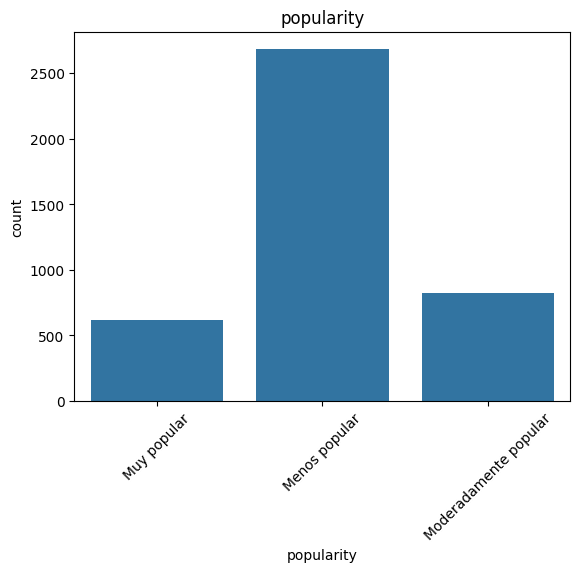

In [64]:
sns.countplot(x=data['popularity'])
plt.title(f"popularity")
plt.xticks(rotation=45)
plt.show()

##Entrenamiento del modelo

In [65]:
X = data[['critic_score', 'total_sales']]
Y = data['popularity']

#División de datos para entrenamiento y pruebas
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print(X_train.shape, X_test.shape)

(3300, 2) (826, 2)


In [67]:
rfc = RandomForestClassifier(random_state = 100)
rfc.fit(X_train, Y_train)

Y_pred = rfc.predict(X_test)


##Análisis de resultados

El modelo desarrollado para clasificar la popularidad de los videojuegos tiene una precisión de 99%. Además, el modelo tiene un número suficiente de ejemplos en cada categoría para determinar las diferentes categorías de popularidad a partir de las variables independientes utilizadas.

In [68]:
print("Reporte de clasificación del modelo:\n", classification_report(Y_test, Y_pred))

Reporte de clasificación del modelo:
                        precision    recall  f1-score   support

        Menos popular       1.00      1.00      1.00       519
Moderadamente popular       0.98      0.98      0.98       172
          Muy popular       0.99      0.99      0.99       135

             accuracy                           0.99       826
            macro avg       0.99      0.99      0.99       826
         weighted avg       0.99      0.99      0.99       826



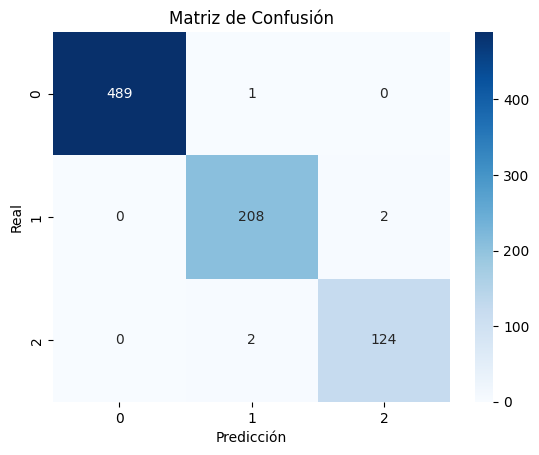

In [44]:
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


**Importancia de las variables del modelo**

El total de ventas es la variable más influyente para determinar la popularidad de un videojuego. Por otro lado, aunque en menor medida, la calificación otorgada al juego también contribuye a su popularidad dado que este indicador influye en las ventas  totales.

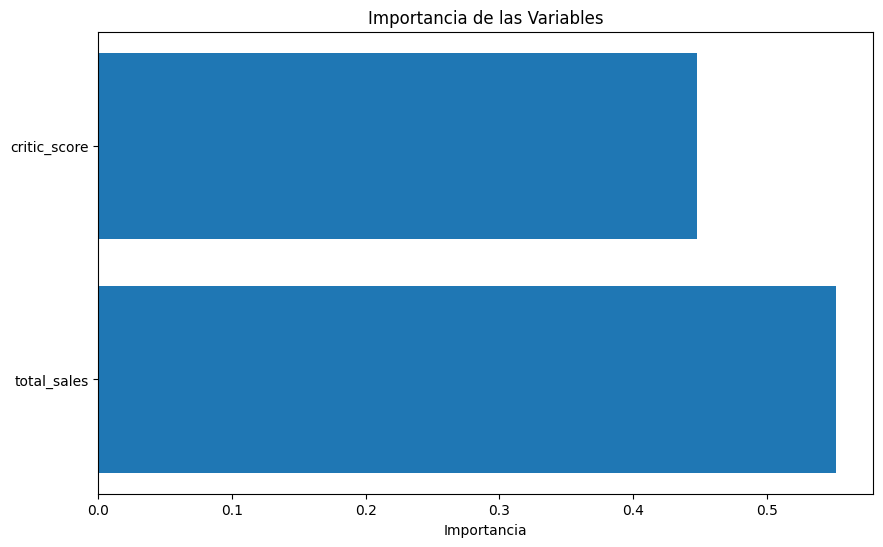

In [70]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rfc.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importancia')
plt.title('Importancia de las Variables')
plt.show()
